# ItemItem Result Analysis

In [20]:
import pandas as pd
import numpy as np
import sqlite3
from lenskit.algorithms.item_knn import ItemItem
%matplotlib inline

## Compare Predictions

In [2]:
sample = pd.read_csv('build/pairs-ml-100k.csv', names=['user', 'item'])
sample.head()

,user,item
0,147,274
1,147,302
2,147,710
3,147,890
4,147,182


In [3]:
java = pd.read_csv('build/lenskit/item-item-ml-100k-preds.csv')
java = pd.merge(sample, java, how='outer')
java.head()

,user,item,prediction
0,147,274,3.848578
1,147,302,4.710038
2,147,710,4.053542
3,147,890,1.980225
4,147,182,4.047028


In [4]:
lkpy = pd.read_csv('build/lkpy/item-item-ml-100k-preds.csv')
lkpy.head()

,user,item,prediction
0,2,967,3.244902
1,2,1671,NaN
2,2,1467,NaN
3,2,1544,2.960666
4,2,649,3.692182


In [5]:
merged = pd.merge(java.rename(columns={'prediction': 'java'}), lkpy.rename(columns={'prediction': 'lkpy'}))
merged.head()

,user,item,java,lkpy
0,147,274,3.848578,3.848578
1,147,302,4.710038,4.710038
2,147,710,4.053542,4.053542
3,147,890,1.980225,1.980225
4,147,182,4.047028,4.047028


In [6]:
merged['diff'] = merged.java - merged.lkpy
merged['diff'].describe()

count    1.019000e+03
mean    -3.323042e-17
std      3.921020e-16
min     -2.664535e-15
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      1.776357e-15
Name: diff, dtype: float64

In [7]:
merged['status'] = 'both'
merged['status'][merged.java.isna()] = 'lkpy-only'
merged['status'][merged.lkpy.isna()] = 'java-only'
merged['status'][merged.lkpy.isna() & merged.java.isna()] = 'neither'
merged.groupby('status').user.count()

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


status
both       1019
neither     981
Name: user, dtype: int64

## Parameter Sweep

In [29]:
db_url = 'sqlite:///build/sweep-item-item-ml-100k.sqlite'

In [32]:
runs = pd.read_sql('runs', db_url).set_index('index')
runs.index.name=None
runs.head()

,Partition,PredictTime,TrainTime,max_neighbors
0,0,0.944593,3.470585,5
0,0,0.910332,0.220910,10
0,0,0.967834,0.264059,15
0,0,0.977081,0.287227,20
0,0,0.752874,0.261323,30


In [34]:
preds = pd.read_sql('predictions', db_url).set_index('index')
preds.index.name = None
preds.head()

,user,item,rating,timestamp,prediction,max_neighbors
16960,10,558,4,877886722,4.029866,5
31188,10,134,5,877889131,5.110068,5
18504,10,1,4,877888877,3.991893,5
93161,10,610,4,877888613,4.060614,5
15952,10,183,5,877893020,4.433188,5


In [36]:
preds['error'] = preds.rating - preds.prediction
preds['sqerr'] = preds.error * preds.error
mse = preds.groupby('max_neighbors').sqerr.mean()
rmse = np.sqrt(mse)
rmse

max_neighbors
5      0.963067
10     0.941576
15     0.938865
20     0.938708
30     0.942013
40     0.942298
50     0.943222
60     0.944090
70     0.944832
80     0.945320
90     0.945660
100    0.946159
125    0.946589
150    0.947044
Name: sqerr, dtype: float64

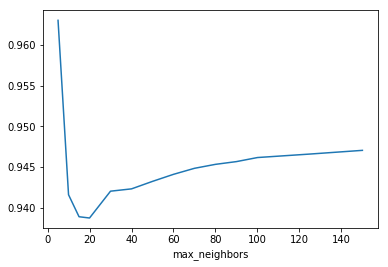

In [37]:
rmse.plot()

## Some debugging of similarities

In [8]:
algo = ItemItem(20)
model = algo.load_model('build/lkpy/item-item-ml-100k.hdf')

In [9]:
matr = model.sim_matrix.tocoo()

In [10]:
p_matr = pd.DataFrame({'item': model.items[matr.row], 'neighbor': model.items[matr.col], 'similarity': matr.data})
p_matr.head()

,item,neighbor,similarity
0,242,882,0.345919
1,242,883,0.327577
2,242,884,0.327070
3,242,995,0.298025
4,242,306,0.277046


In [11]:
j_matr = pd.read_csv('build/lenskit/item-item-ml-100k.matrix.csv')
j_matr.head()

,item,neighbor,similarity
0,1,2,0.091331
1,1,3,0.074554
2,1,4,0.051377
3,1,5,0.114383
4,1,6,0.073914


In [12]:
m2 = pd.merge(p_matr.rename(columns={'similarity': 'pysim'}), j_matr.rename(columns={'similarity': 'jsim'}), how='outer')
m2['diff'] = m2.pysim - m2.jsim
m2.head()

,item,neighbor,pysim,jsim,diff
0,242,882,0.345919,0.345919,0.000000e+00
1,242,883,0.327577,0.327577,1.110223e-16
2,242,884,0.327070,0.327070,5.551115e-17
3,242,995,0.298025,0.298025,-1.110223e-16
4,242,306,0.277046,0.277046,5.551115e-17


In [13]:
m2[m2.pysim.isna()]

,item,neighbor,pysim,jsim,diff


In [14]:
m2['diff'].describe()

count    1.216304e+06
mean    -6.597480e-19
std      3.819798e-17
min     -1.831868e-15
25%     -1.387779e-17
50%      0.000000e+00
75%      1.257675e-17
max      1.387779e-15
Name: diff, dtype: float64

In [15]:
mi_counts = pd.Series(model.counts, index=model.items)
mi_counts.head()

242     988
302    1139
377     857
51     1161
346     791
dtype: int32

In [16]:
mi_counts.describe()

count    1682.000000
mean      723.129608
std       324.924716
min         0.000000
25%       574.750000
50%       822.000000
75%       961.000000
max      1206.000000
dtype: float64

In [17]:
jmi_counts = j_matr.groupby('item').neighbor.count()
jmi_counts.head()

item
1    1197
2    1188
3    1066
4     927
5     910
Name: neighbor, dtype: int64

In [18]:
jmi_counts.describe()

count    1516.000000
mean      802.311346
std       231.460154
min        58.000000
25%       665.000000
50%       852.000000
75%       974.000000
max      1206.000000
Name: neighbor, dtype: float64

In [19]:
diff = mi_counts[mi_counts > 0] - jmi_counts

In [20]:
diff.describe()

count    1516.0
mean        0.0
std         0.0
min         0.0
25%         0.0
50%         0.0
75%         0.0
max         0.0
dtype: float64